# Land Use / Land Cover Segmentation Using Sentinel-2 and Random Forest

This workflow demonstrates how to use [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) satellite imagery for segmenting land use / land cover (LULC) using a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier. We will pursue this objective by integrating ground truth forest areas from the **National Forest Classification Dataset (LULC)** from 2018. To make this scalable to all of Vanuatu, we use an [administrative boundaries dataset from Pacific data hub](https://pacificdata.org/data/dataset/2016_vut_phc_admin_boundaries/resource/66ae054b-9b67-4876-b59c-0b078c31e800).

In this notebook, we will demonstrate the following:

1. **Data Acquisition**:
   - We use **Sentinel-2 L2A** data (Level-2A provides surface reflectance) accessed via the [AWS STAC catalog](https://registry.opendata.aws/). The search is filtered by parameters like a region of interest (AOI), time range, and cloud cover percentage to obtain suitable imagery.
   
2. **Preprocessing**:
   - The Sentinel-2 imagery contains several spectral bands (e.g., Red, Green, Blue, and Near-Infrared). These are extracted and combined into a single dataset for analysis. Additionally, the imagery is masked to remove areas outside the AOI and focus on the relevant pixels.
  
3. **Feature Extraction**:
   - Features for the classifier are extracted from the Sentinel-2 spectral bands. Here, we will use the reflectance values from the Red, Green, Blue, and Near-Infrared (NIR) bands. We will mask out clouds from these bands before further analysis.

4. **Ground Truth Data Integration**:
   - A shapefile containing polygons attributed by land cover/land use is loaded into a [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). This allows us to create multi-class labels for the pixels in the Sentinel-2 imagery.
  
5. **Data Splitting**:
   - To ensure correct model training, we split the features and labels into training (80%) and testing (20%) sets. A 'seed' value is used for the random number generator to ensure this random split is reproducible.

6. **Random Forest Classification**:
   - We train a **Random Forest** classifier to predict planted forest areas. The `n_estimators` parameter is a key hyperparameter, determining the number of decision trees in the forest. Random Forest leverages the collective wisdom of multiple decision trees to make accurate predictions.

7. **Prediction**:
   - We will use the trained classifier to predict the likelihood of lulc types for each pixel in the image. 

8. **Evaluation**:
   - After making predictions on the test set, we evaluate the model's performance using metrics such as accuracy and F1-score. This allows us to assess the performance of the Random Forest model and the effectiveness of the selected features.

9. **Visualization**:
   - We visualize the predictions by plotting the classified map, where lulc types are indicated by specific color codes.

At the end, you will have trained a model to predict land use + land cover in Vanuatu.

![result](https://github.com/user-attachments/assets/6794df2b-45b4-4c6a-923b-98b33e305a39)

In [1]:
!mamba install --channel rapidsai --quiet --yes cuml

In [2]:
import dask.dataframe as dd
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import odc.stac
import rasterio.features
from shapely.geometry import box
import xarray as xr
import rioxarray as rxr
# import xgboost as xgb
from cuml import RandomForestClassifier
from dask import delayed, compute
from geocube.api.core import make_geocube
from pystac_client import Client
from shapely.geometry import Polygon, shape, box, mapping
from tqdm import tqdm  # for progress bar
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
#from sklearn.model_selection import train_test_split
from dask_ml.model_selection import train_test_split

## Data Acquisition

Let's read the LULC data into a GeoDataFrame. 

A [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/geodataframe.html) is a type of data structure used to store geographic data in Python, provided by the [GeoPandas](https://geopandas.org/en/stable/) library. It extends the functionality of a pandas DataFrame to handle spatial data, enabling geospatial analysis and visualization. Like a pandas DataFrame, a GeoDataFrame is a tabular data structure with labeled axes (rows and columns), but it adds special features to work with geometric objects, such as:
- a geometry column
- a CRS
- accessibility to spatial operations (e.g.  intersection, union, buffering, and spatial joins)

In [3]:
lulc_gdf = gpd.read_file("./ROIs/ROIs_v5.shp") #"./ROIs_v5.shp")

In [4]:
admin_boundaries_gdf = gpd.read_file("./2016_phc_vut_pid_4326.geojson")

In [5]:
admin_boundaries_gdf.head(2)

,pid,pname,geometry
0,1,TORBA,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
1,2,SANMA,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."


In [6]:
len(lulc_gdf), len(admin_boundaries_gdf)

(1655, 6)

We can check out the attributes associated with this dataset:

In [7]:
lulc_gdf.columns

Index(['PID', 'Pname', 'AC2022', 'ACNAME22', 'Area', 'Area KMsq', 'ROI',
       'layer', 'path', 'geometry'],
      dtype='object')

Let's see which classes are available to us in the most recent LULC column.

In [8]:
lulc_gdf.ROI.unique()

array(['Grassland', 'Agriculture', 'Barelands', 'Builtup Infrastructure',
       'Coconut Plantations', 'Dense_Forest', 'Mangroves', 'Open_Forest',
       'Water Bodies'], dtype=object)

And view a subset of the data (shuffled for more variety in the 10 samples):

In [9]:
lulc_gdf.sample(frac=1).head(10)

,PID,Pname,AC2022,ACNAME22,Area,Area KMsq,ROI,layer,path,geometry
433,5.0,SHEFA,518,Eton,321744848,321.7,Dense_Forest,DENSE_FOREST_AC,C:\Users\User\OneDrive - Vanuatu Gov\Documents...,"POLYGON Z ((869631.876 8041007.5 0, 869632.5 8..."
8,5.0,SHEFA,516,Erakor,107669890,107.7,Grassland,None,None,"POLYGON Z ((856983.997 8035397.037 0, 856957.5..."
1541,4.0,MALAMPA,406,South Malekula,232886516,232.9,Water Bodies,WB_no_dup_AC,C:\Users\User\OneDrive - Vanuatu Gov\Documents...,"POLYGON Z ((802034.409 8173625.743 0, 802091.7..."
1538,4.0,MALAMPA,406,South Malekula,232886516,232.9,Water Bodies,WB_no_dup_AC,C:\Users\User\OneDrive - Vanuatu Gov\Documents...,"POLYGON Z ((801476.401 8171284.885 0, 801488.3..."
104,5.0,SHEFA,511,North Efate,84907300,84.9,Grassland,None,None,"POLYGON Z ((862470.139 8057248.704 0, 862486.4..."
1144,3.0,PENAMA,306,South Maewo,170288054,170.3,Dense_Forest,Dens_no_dup_AC,C:\Users\User\OneDrive - Vanuatu Gov\Documents...,"POLYGON Z ((836905.152 8308214.839 0, 836898.1..."
1132,5.0,SHEFA,502,Vermaul,175390841,175.4,Dense_Forest,Dens_no_dup_AC,C:\Users\User\OneDrive - Vanuatu Gov\Documents...,"POLYGON Z ((836903.034 8146318.392 0, 836999.4..."
1463,5.0,SHEFA,511,North Efate,84907300,84.9,Water Bodies,WB_no_dup_AC,C:\Users\User\OneDrive - Vanuatu Gov\Documents...,"POLYGON Z ((867756.866 8054165.864 0, 867766.7..."
557,5.0,SHEFA,518,Eton,321744848,321.7,Open_Forest,OPEN_FOREST_AC,C:\Users\User\OneDrive - Vanuatu Gov\Documents...,"POLYGON Z ((873382.5 8043062.5 0, 873389.451 8..."
1311,2.0,SANMA,203,West Santo,704407863,704.4,Open_Forest,OF_no_dup_AC,C:\Users\User\OneDrive - Vanuatu Gov\Documents...,"POLYGON Z ((674899.387 8332224.566 0, 674898.6..."


We can also plot the vector dataset, and color code the polygons by the relevant LULC column.

<Axes: >

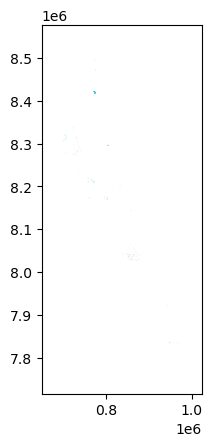

In [10]:
lulc_gdf.plot(column='ROI')

Create raster image and label xarray datarrays for each admin boundary.

In [11]:
admin_boundaries_gdf

,pid,pname,geometry
0,1,TORBA,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
1,2,SANMA,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."
2,3,PENAMA,"MULTIPOLYGON (((168.2481 -15.78748, 168.24811 ..."
3,4,MALAMPA,"MULTIPOLYGON (((167.48039 -16.60241, 167.47951..."
4,5,SHEFA,"MULTIPOLYGON (((168.30762 -17.77548, 168.30773..."
5,6,TAFEA,"MULTIPOLYGON (((169.84994 -20.25396, 169.85015..."


In [12]:
YEAR = 2018
PROVINCES_TRAIN = ["TORBA", "SANMA", "PENAMA", "MALAMPA", "SHEFA"] #, "TAFEA"]
PROVINCE_TEST = "TAFEA"

In [13]:
admin_boundaries_gdf = admin_boundaries_gdf.set_index(keys="pname")  # set province name as the index

In [14]:
admin_boundaries_gdf

,pid,geometry
pname,,
TORBA,1,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
SANMA,2,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."
PENAMA,3,"MULTIPOLYGON (((168.2481 -15.78748, 168.24811 ..."
MALAMPA,4,"MULTIPOLYGON (((167.48039 -16.60241, 167.47951..."
SHEFA,5,"MULTIPOLYGON (((168.30762 -17.77548, 168.30773..."
TAFEA,6,"MULTIPOLYGON (((169.84994 -20.25396, 169.85015..."


In [15]:
GEOMS_TRAIN = admin_boundaries_gdf.loc[PROVINCES_TRAIN].geometry.tolist()
GEOMS_TRAIN

[<MULTIPOLYGON (((168.039 -14.48, 168.039 -14.48, 168.039 -14.48, 168.039 -14...>,
 <MULTIPOLYGON (((167.256 -15.715, 167.256 -15.715, 167.256 -15.714, 167.256 ...>,
 <MULTIPOLYGON (((168.248 -15.787, 168.248 -15.787, 168.248 -15.787, 168.249 ...>,
 <MULTIPOLYGON (((167.48 -16.602, 167.48 -16.602, 167.478 -16.601, 167.477 -1...>,
 <MULTIPOLYGON (((168.308 -17.775, 168.308 -17.775, 168.308 -17.775, 168.308 ...>]

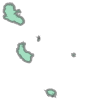

In [16]:
GEOM_TEST = admin_boundaries_gdf.loc[PROVINCE_TEST].geometry
GEOM_TEST

In [17]:
STAC_URL = "http://stac.digitalearthpacific.org/"
stac_client = Client.open(STAC_URL)

In [18]:
# Collect s2_data per province in a list
s2_data_train_list = []

for pname, geom in tqdm(zip(PROVINCES_TRAIN, GEOMS_TRAIN), total=len(GEOMS_TRAIN), desc="Loading GeoMAD per province"):
    try:
        # Query STAC for this province
        s2_search = stac_client.search(
            collections=["dep_s2_geomad"],
            intersects=mapping(geom),  # GeoJSON dict
            datetime=str(YEAR),
        )
        s2_items = s2_search.item_collection()

        if len(s2_items) == 0:
            print(f"No items found for {pname}")
            continue

        # Load data from items
        s2_data = odc.stac.load(
            items=s2_items,
            bands=["blue", "green", "red", "nir08", "swir16"],
            chunks={"x": 1024, "y": 1024, "bands": -1, "time": -1},
            resolution=20,
        )

        s2_data_train_list.append(s2_data)

    except Exception as e:
        print(f"Error loading {pname}: {e}")



Loading GeoMAD per province: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


In [19]:
# gdf_test = gpd.read_file(geos[0])
gdf_test = lulc_gdf.query(expr=f"Pname == '{PROVINCE_TEST}'")

s2_search = stac_client.search(
    collections=["dep_s2_geomad"], # Sentinel-2 Geometric Median and Absolute Deviations (GeoMAD) over the Pacific.
    intersects=GEOM_TEST, 
    datetime=str(YEAR),
)
# Retrieve all items from search results
s2_items = s2_search.item_collection()
print("len(s2_items): ", len(s2_items))

s2_data_test = odc.stac.load(
    items=s2_items,
    bands=["blue", "green", "red", "nir08", "swir16"],
    chunks={'x': 1024, 'y': 1024, 'bands': -1, 'time': -1},
    resolution=20,
)
s2_data_test

len(s2_items):  4


<xarray.Dataset> Size: 1GB
Dimensions:      (y: 14400, x: 9600, time: 1)
Coordinates:
  * y            (y) float64 115kB -2.08e+06 -2.08e+06 ... -2.368e+06 -2.368e+06
  * x            (x) float64 77kB 2.088e+06 2.088e+06 ... 2.28e+06 2.28e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2018-01-01
Data variables:
    blue         (time, y, x) uint16 276MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 276MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 276MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    nir08        (time, y, x) uint16 276MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    swir16       (time, y, x) uint16 276MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [20]:
# Keep projection aligned with raster
raster_crs = s2_data_train_list[0].rio.crs

# Reproject the full subset once
gdf_reprojected_train = admin_boundaries_gdf.loc[PROVINCES_TRAIN].to_crs(crs=raster_crs)

# Create a dictionary of buffered geometries per province
geom_buffered_train = {
    pname: gdf_reprojected_train.loc[pname].geometry.buffer(5000)
    for pname in PROVINCES_TRAIN
}

In [21]:
geom_train_buffered_list = list(geom_buffered_train.values())
geom_train_buffered_list

[<MULTIPOLYGON (((2001147.517 -1614635.929, 2001165.415 -1614530.9, 2001286.8...>,
 <POLYGON ((1836761.34 -1658659.221, 1836811.138 -1658407.712, 1836958.743 -1...>,
 <MULTIPOLYGON (((2003686.571 -1664414.707, 2003707.288 -1664369.336, 2003776...>,
 <MULTIPOLYGON (((1988978.532 -1819751.827, 1988964.375 -1819468.323, 1988978...>,
 <MULTIPOLYGON (((2013229.917 -1868836.526, 2013232.135 -1868799.699, 2013267...>]

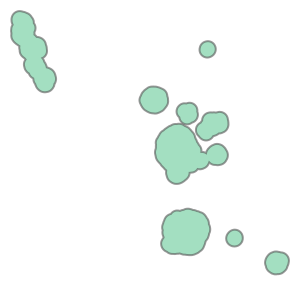

In [22]:
geom_train_buffered_list[0]

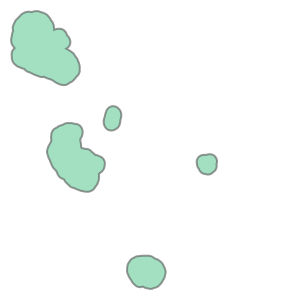

In [23]:
# Keep projection aligned with raster
raster_crs = s2_data_test.rio.crs

# Get only the select province and reproject
gdf_reprojected_test = admin_boundaries_gdf.loc[[PROVINCE_TEST]].to_crs(crs=raster_crs)

# Buffer in raster units (meters if UTM)
geom_buffered_test = gdf_reprojected_test.buffer(distance=5000)[PROVINCE_TEST]
geom_buffered_test

In [24]:
# Make sure the keys match — we'll zip province names, geometries, and s2 datasets
s2_train_clipped_list = []

for pname, geom, s2_data in zip(PROVINCES_TRAIN, geom_buffered_train.values(), s2_data_train_list):
    try:
        # Clip the dataset to the buffered province geometry
        s2_clipped = s2_data.rio.clip(
            geometries=[mapping(geom)],
            crs=s2_data.rio.crs,
            drop=True
        )
        s2_train_clipped_list.append(s2_clipped)
    except Exception as e:
        print(f"Error clipping data for {pname}: {e}")

In [25]:
s2_train_clipped_list[0]

<xarray.Dataset> Size: 766MB
Dimensions:      (y: 8518, x: 8988, time: 1)
Coordinates:
  * y            (y) float64 68kB -1.453e+06 -1.453e+06 ... -1.624e+06
  * x            (x) float64 72kB 1.837e+06 1.837e+06 ... 2.016e+06 2.016e+06
  * time         (time) datetime64[ns] 8B 2018-01-01
    spatial_ref  int64 8B 0
Data variables:
    blue         (time, y, x) uint16 153MB dask.array<chunksize=(1, 800, 220), meta=np.ndarray>
    green        (time, y, x) uint16 153MB dask.array<chunksize=(1, 800, 220), meta=np.ndarray>
    red          (time, y, x) uint16 153MB dask.array<chunksize=(1, 800, 220), meta=np.ndarray>
    nir08        (time, y, x) uint16 153MB dask.array<chunksize=(1, 800, 220), meta=np.ndarray>
    swir16       (time, y, x) uint16 153MB dask.array<chunksize=(1, 800, 220), meta=np.ndarray>

In [26]:
# Clip test province
s2_clipped_test = s2_data_test.rio.clip(geometries=[geom_buffered_test])

In [27]:
# Plot sample train province
s2_rgb = s2_train_clipped_list[0][["red", "green", "blue"]] 
s2_rgb_array = s2_rgb.to_array("band")  # now dims: band, y, x
s2_rgb_array_squeezed = s2_rgb_array.squeeze(dim="time", drop=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


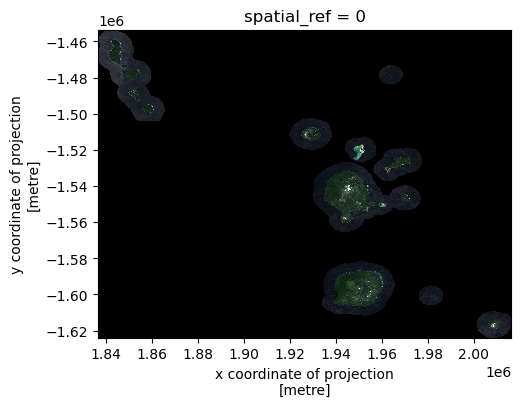

In [28]:
s2_rgb_array_squeezed.plot.imshow(size=4, vmin=0, vmax=4000)

In [29]:
# Calculate remote sensing indices useful for mapping LULC
def compute_indices(ds):
    red = ds["red"]
    green = ds["green"]
    blue = ds["blue"]
    nir = ds["nir08"]
    swir = ds["swir16"]
    eps = 1e-6
    return xr.Dataset({
        "NDVI": (nir - red) / (nir + red + eps),
        "MNDWI": (green - swir) / (green + swir + eps),
        "SAVI": ((nir - red) / (nir + red + eps)) * 1.5,
        "BSI": ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue) + eps),
    })

index_data_train_list = []

for s2_clipped in s2_train_clipped_list:
    index_data = compute_indices(s2_clipped).squeeze("time", drop=True)
    index_data_train_list.append(index_data)

index_data_test = compute_indices(s2_clipped_test).squeeze("time", drop=True)
print(index_data_train_list[0])

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 8518, x: 8988)
Coordinates:
  * y            (y) float64 68kB -1.453e+06 -1.453e+06 ... -1.624e+06
  * x            (x) float64 72kB 1.837e+06 1.837e+06 ... 2.016e+06 2.016e+06
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (y, x) float64 612MB dask.array<chunksize=(800, 220), meta=np.ndarray>
    MNDWI        (y, x) float64 612MB dask.array<chunksize=(800, 220), meta=np.ndarray>
    SAVI         (y, x) float64 612MB dask.array<chunksize=(800, 220), meta=np.ndarray>
    BSI          (y, x) float64 612MB dask.array<chunksize=(800, 220), meta=np.ndarray>


In [30]:
# Rasterize labels
width_test, height_test = s2_clipped_test.x.size, s2_clipped_test.y.size
epsg = s2_clipped_test.rio.crs.to_epsg()
bands = ['red', 'green', 'blue', 'nir08']
unique_classes = gdf_test['ROI'].unique()
class_mapping = {cls: i+1 for i, cls in enumerate(unique_classes)}

# Add numerical column
gdf_test['ROI_numeric'] = gdf_test['ROI'].map(class_mapping)

#print(gdf_.ROI.unique(), gdf_.ROI_numeric.unique())
gdf_test = gdf_test.to_crs(epsg=epsg)
# Define the resolution and bounds based on Sentinel-2 features
resolution = s2_clipped_test.rio.resolution()
bounds_test = s2_clipped_test.rio.bounds()

gdf_rpg = lulc_gdf.to_crs(s2_clipped_test.rio.crs)

unique_classes = gdf_rpg['ROI'].unique()
class_mapping = {cls: i+1 for i, cls in enumerate(unique_classes)}

# Add numerical column
gdf_rpg['ROI_numeric'] =  gdf_rpg['ROI'].map(class_mapping)

raster_bounds_test = box(*s2_clipped_test.rio.bounds())
gdf_test_clipped = gdf_rpg[gdf_rpg.intersects(raster_bounds_test)]

print(f"Before: {len(gdf_rpg)} | After: {len(gdf_test_clipped)}")

# Rasterize the vector dataset to match Sentinel-2
rasterized_labels_test = make_geocube(
    vector_data=gdf_test_clipped,
    measurements=["ROI_numeric"], 
    like=s2_clipped_test,  # Align with the features dataset
)

print("rasterized_labels_test: ", rasterized_labels_test)

Before: 1655 | After: 158
rasterized_labels_test:  <xarray.Dataset> Size: 603MB
Dimensions:      (y: 10081, x: 7471)
Coordinates:
  * y            (y) float64 81kB -2.092e+06 -2.092e+06 ... -2.293e+06
  * x            (x) float64 60kB 2.109e+06 2.109e+06 ... 2.258e+06 2.258e+06
    spatial_ref  int64 8B 0
Data variables:
    ROI_numeric  (y, x) float64 603MB nan nan nan nan nan ... nan nan nan nan


In [31]:
# Rasterize labels
rasterized_labels_train_dict = {}
gdf_train_clipped_dict = {}
metadata_dict = {}

for s2_clipped_train, pname in zip(s2_train_clipped_list, PROVINCES_TRAIN):
    print(f"\n Processing province: {pname}")

    # Sentinel-2 metadata
    width = s2_clipped_train.sizes['x']
    height = s2_clipped_train.sizes['y']
    epsg = s2_clipped_train.rio.crs.to_epsg()
    resolution = s2_clipped_train.rio.resolution()
    bounds = s2_clipped_train.rio.bounds()
    raster_bounds = box(*bounds)

    # Reproject LULC GeoDataFrame to match S2 CRS
    gdf_rpg = lulc_gdf.to_crs(epsg)

    # Class mapping (safe per-province if needed)
    unique_classes = gdf_rpg['ROI'].unique()
    class_mapping = {cls: i + 1 for i, cls in enumerate(unique_classes)}
    gdf_rpg['ROI_numeric'] = gdf_rpg['ROI'].map(class_mapping)

    # Clip vector LULC to S2 bounds
    gdf_train_clipped = gdf_rpg[gdf_rpg.intersects(raster_bounds)]
    print(f"Vector features: {len(gdf_rpg)} → Clipped: {len(gdf_train_clipped)}")

    if len(gdf_train_clipped) == 0:
        print(f"No vector data found for province: {pname}, skipping rasterization.")
        continue

    # Rasterize clipped vector labels
    rasterized_labels_train = make_geocube(
        vector_data=gdf_train_clipped,
        measurements=["ROI_numeric"],
        like=s2_clipped_train
    )

    # Store outputs
    rasterized_labels_train_dict[pname] = rasterized_labels_train
    gdf_train_clipped_dict[pname] = gdf_train_clipped
    metadata_dict[pname] = {
        "width": width,
        "height": height,
        "epsg": epsg,
        "resolution": resolution,
        "bounds": bounds,
        "class_mapping": class_mapping
    }



 Processing province: TORBA
Vector features: 1655 → Clipped: 51

 Processing province: SANMA
Vector features: 1655 → Clipped: 317

 Processing province: PENAMA
Vector features: 1655 → Clipped: 43

 Processing province: MALAMPA
Vector features: 1655 → Clipped: 232

 Processing province: SHEFA
Vector features: 1655 → Clipped: 866


In [32]:
rasterized_labels_train_dict["SHEFA"]

<xarray.Dataset> Size: 216MB
Dimensions:      (y: 7804, x: 3457)
Coordinates:
  * y            (y) float64 62kB -1.853e+06 -1.853e+06 ... -2.009e+06
  * x            (x) float64 28kB 2.012e+06 2.012e+06 ... 2.081e+06 2.081e+06
    spatial_ref  int64 8B 0
Data variables:
    ROI_numeric  (y, x) float64 216MB nan nan nan nan nan ... nan nan nan nan

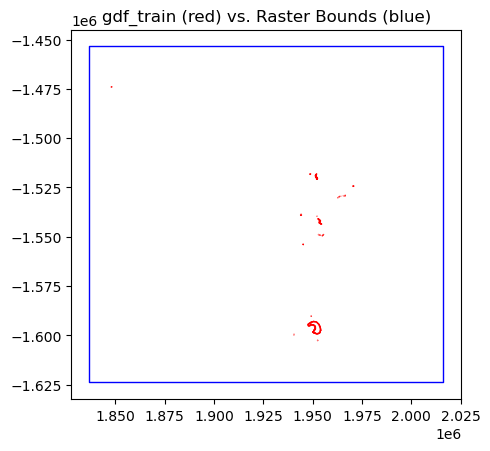

In [33]:
fig, ax = plt.subplots()
gdf_train_clipped_dict["TORBA"].plot(ax=ax, facecolor="none", edgecolor="red")
bbox = box(*s2_train_clipped_list[0].rio.bounds())
gpd.GeoSeries([bbox], crs=s2_train_clipped_list[0].rio.crs).plot(ax=ax, facecolor="none", edgecolor="blue")
plt.title("gdf_train (red) vs. Raster Bounds (blue)")
plt.show()


In [34]:
gdf_train_clipped_dict["TORBA"].ROI.unique()

array(['Barelands', 'Coconut Plantations', 'Dense_Forest', 'Mangroves',
       'Water Bodies'], dtype=object)

In [35]:
np.unique(rasterized_labels_train_dict["TORBA"]['ROI_numeric'].values)

array([ 3.,  5.,  6.,  7.,  9., nan])

In [36]:
features_list = []
labels_list = []

for i, prov_name in enumerate(PROVINCES_TRAIN):
    # Stack spatial dimensions first
    features_train = index_data_train_list[i].to_array().stack(flattened_pixel=("y", "x"))
    labels_train = rasterized_labels_train_dict[prov_name].to_array().stack(flattened_pixel=("y", "x"))
    
    # Compute mask for valid pixels (no NaNs across all features or labels)
    mask = (
        np.isfinite(features_train).all(dim="variable") &
        np.isfinite(labels_train).all(dim="variable")
    ).compute()
    
    # Apply the mask to drop invalid pixels
    features_train = features_train[:, mask].transpose("flattened_pixel", "variable").compute()
    labels_train = labels_train[:, mask].transpose("flattened_pixel", "variable").squeeze().compute()

    # Convert labels to zero-based (subtract min label)
    min_label = labels_train.min().item()
    labels_train = labels_train - min_label
    labels_train = labels_train.astype(int)

    features_list.append(features_train)
    labels_list.append(labels_train)

# Concatenate all provinces along the flattened_pixel dimension
features_train = xr.concat(features_list, dim="flattened_pixel")
labels_train = xr.concat(labels_list, dim="flattened_pixel")

print("Combined features_train shape:", features_train.shape)
print("Combined zero-based labels_train shape:", labels_train.shape)


Combined features_train shape: (144424, 4)
Combined zero-based labels_train shape: (144424,)


In [37]:
np.unique(labels_train.values)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [38]:
features_test = index_data_test.to_array().stack(flattened_pixel=("y", "x"))
labels_test = rasterized_labels_test.to_array().stack(flattened_pixel=("y", "x"))

test_mask = (
    np.isfinite(features_test).all(dim="variable") &
    np.isfinite(labels_test).all(dim="variable")
).compute()

features_test = features_test[:].transpose("flattened_pixel", "variable").compute()
labels_test = labels_test[:].transpose("flattened_pixel", "variable").squeeze().compute()
print("labels_test values:", np.unique(labels_test.values))

# Convert nan to 255
labels_test = labels_test.fillna(255).astype(int)
# Convert labels to zero-based (subtract min label)
min_label = labels_test.min().item()
labels_test = labels_test - min_label
labels_test = labels_test.astype(int)
print("labels_test values:", np.unique(labels_test.values))

print("features_test shape:", features_test.shape)
print("labels_test shape:", labels_test.shape)

labels_test values: [ 2.  3.  4.  6.  8.  9. nan]
labels_test values: [  0   1   2   4   6   7 253]
features_test shape: (75315151, 4)
labels_test shape: (75315151,)


In [39]:
len(features_train), len(labels_train) #, len(features_test), len(labels_test)

(144424, 144424)

In [40]:
features_train

<xarray.DataArray (flattened_pixel: 144424, variable: 4)> Size: 5MB
array([[ 0.48168915, 12.27191621,  0.72253373,  6.21322691],
       [ 0.37543493, 12.18053435,  0.5631524 ,  6.12255407],
       [ 0.50874738, 15.09099571,  0.76312106,  0.02512077],
       ...,
       [ 0.84295025, 20.35213945,  1.26442537,  6.86051146],
       [ 0.83957387, 19.35247883,  1.2593608 ,  6.68500377],
       [ 0.85587549, 20.27951883,  1.28381323,  6.72844874]])
Coordinates:
    spatial_ref      int64 8B 0
  * variable         (variable) object 32B 'NDVI' 'MNDWI' 'SAVI' 'BSI'
  * flattened_pixel  (flattened_pixel) object 1MB MultiIndex
  * y                (flattened_pixel) float64 1MB -1.474e+06 ... -2.003e+06
  * x                (flattened_pixel) float64 1MB 1.848e+06 ... 2.05e+06

## Data Splitting

Now that we have the arrays flattened, we can split the datasets into training and testing partitions. We will reserve 80 percent of the data for training, and 20 percent for testing.

In [41]:
#features_flattened.shape, labels_flattened.shape

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    features_train, labels_train, test_size=0.2, random_state=42, shuffle=True
)

In [43]:
#X_train, X_test, y_train, y_test = features_train, features_test, labels_train, labels_test

Ensure all labels are in each partition.

In [44]:
np.unique(y_train), np.unique(y_test) 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

In [45]:
len(X_train), len(X_test), len(y_train), len(y_test)

(115539, 28885, 115539, 28885)

## Random Forest Classification

Now we will set up a small [random forest classifider](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with 10 trees. We use a [seed](https://towardsdatascience.com/why-do-we-set-a-random-state-in-machine-learning-models-bb2dc68d8431) (`random_state`) to ensure reproducibility. Calling the `.fit()` method on the classifier will initiate training.

In [46]:
%%time
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42) #n_estimators=10
clf.fit(X_train.data, y_train.data)

CPU times: user 768 ms, sys: 1.05 s, total: 1.82 s
Wall time: 1.42 s


RandomForestClassifier()

## Prediction

Once the classifier is finished training, we can use it to make predictions on our test dataset.

In [47]:
# Test the classifier
y_pred = clf.predict(X_test) #.data.compute())

## Evaluation

It's important to know how well our classifier performs relative to the true labels (`y_test`). For this, we can calculate the [accuracy metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to measure agreement between the true and predicted labels.

In [48]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7859


We can also plot a confusion matrix to explore per-class performance.

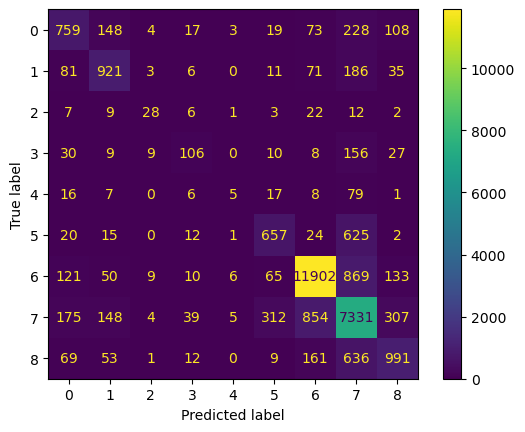

In [49]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

Notice that we see a high variability in the performance across classes. This is likely due to a class imbalance or inter-class differentiation challenge within our training dataset. It's possible that augmentations or class revision may help to address this.

## Visualization

If we want to generate predictions for the entire dataset in order to plot a map of predicted LULC for the entire area of interest, we can do this using the full (un-partitioned) features dataset.

In [50]:
y_pred = clf.predict(features_test)

In [51]:
#y_pred_full = clf.predict(features_test)
#predicted_map = y_pred_full.reshape((height_test, width_test))
predicted_map = y_pred.reshape((height_test, width_test))
predicted_map_xr = xr.DataArray(data=predicted_map, coords=rasterized_labels_test.coords)
print(np.unique(y_pred))
    

[0 1 2 3 4 5 6 7 8]


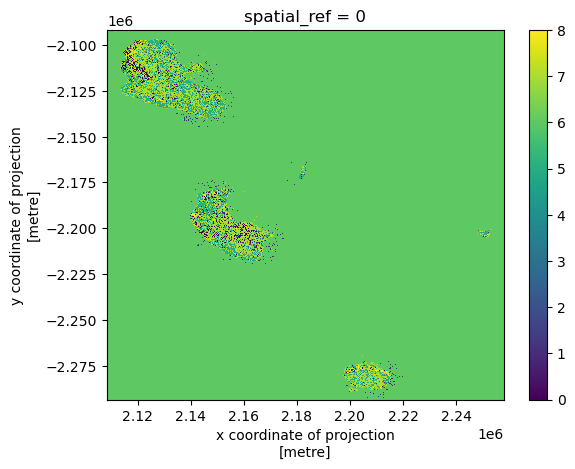

In [52]:
predicted_map_xr.plot(cmap="viridis")

In [ ]:
rasterized_labels_test["ROI_numeric"].plot(cmap="viridis")

In [53]:
"""
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

rasterized_labels_test["ROI_numeric"].plot(ax=axes[0], cmap="viridis")
axes[0].set_title("Ground truth")
axes[0].set_aspect('equal')

predicted_map_xr.plot(ax=axes[1], cmap="viridis")
axes[1].set_title("Predictions")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()
"""

'\nfig, axes = plt.subplots(1, 2, figsize=(12, 6))\n\nrasterized_labels_test["ROI_numeric"].plot(ax=axes[0], cmap="viridis")\naxes[0].set_title("Ground truth")\naxes[0].set_aspect(\'equal\')\n\npredicted_map_xr.plot(ax=axes[1], cmap="viridis")\naxes[1].set_title("Predictions")\naxes[1].set_aspect(\'equal\')\n\nplt.tight_layout()\nplt.show()\n'

In [54]:
compatible_array = predicted_map_xr.astype("int32")

# Rasterize to polygons
polygons = list(
    rasterio.features.shapes(compatible_array.values, transform=compatible_array.rio.transform())
)

# Convert polygons to GeoDataFrame
prediction_gdf = gpd.GeoDataFrame(
    [{"geometry": shape(geom), "value": value} for geom, value in polygons],
    crs="EPSG:4326",
)
#print(prediction_gdf)
print(prediction_gdf.value.unique())

prediction_gdf.to_file(f"./predicted_lulc_utm_{PROVINCE_TEST}_{YEAR}.geojson", driver="GeoJSON")

[1. 7. 8. 2. 6. 3. 0. 4. 5.]
